# Multi-cell geolift analysis

In other examples, such as the {doc}`single-cell geolift notebook <geolift1>`, we've seen how we can use Synthetic Control methods to estimate the causal impact of a treatment in one geographic area (geo). In this example, we'll extend the analysis to multiple geographic areas (geos).

This may be a particularly common use case in marketing, where a company may want to understand the impact of a marketing campaign in multiple regions. But these methods are not restricted to marketing of course - the methods shown here are general. Another concrete use case may be in public health, where a public health intervention may be rolled out in multiple regions.

This notebook focusses on the situation where the treatment has already taken place, and now we want to understand the causal effects of the treatments that were executed. Much work likely preceded this analysis, such as asking yourself questions like "which geos should I run the treatment in?", "what should the treatment be?" But these pre-treatment questions are not the focus of this notebook.

We can imagine two scenarios (there may be more), and show how we can tailor our analysis to each.

## Pooled approach

The treatments were similar in kind and/or magnitude in each region. An example of this may be where a company ran the same marketing campaign in multiple test geos. In cases like this, we can imagine that the causal impact of the treatment may be similar in each region. Because the pooled approach aggregates the treated geos before fitting the model, with `mean` aggregation the pooled model estimates the {term}`average treatment effect on the treated` (ATT) across regions. In other words, the pooled estimate answers the question: "what was the causal effect per treated geo?"

## Unpooled approach

The treatments were of different kinds and/or magnitudes in each region. An example of this may be where different marketing campaigns were run in different regions, and perhaps the budgets were different in each region. In cases like this, we can imagine that the causal impact of the treatment may be different in each region. The unpooled approach estimates **individual per-geo causal effects** — a separate ATT for each treated region. The unpooled estimates answer the question: "what was the effect in *this specific* geo?"

Because these two approaches target different causal estimands, it is essential to keep this distinction in mind when interpreting results. We return to this point when we compare the two approaches later in the notebook.

## Generalising from treated to untreated geos

It is also important to note that both approaches estimate the effect of the treatment *on the geos that were actually treated*. This is the ATT. In practice, however, we often want to know whether the same intervention would produce similar effects in *other, untreated* geos — for example, when deciding whether to roll out a campaign nationally.

Generalising from the ATT to untreated geos requires an additional assumption: that the treatment effect measured in the treated geos is representative of what would happen elsewhere. This assumption is more plausible when:

- Treated geos were selected approximately at random, or are otherwise representative of the broader population of geos.
- There is no strong reason to expect treatment effects to vary systematically between treated and untreated geos (i.e. treatment effect homogeneity).

Conversely, if treated geos were cherry-picked — for instance, chosen because they were expected to respond well, or because they are large, urban markets — then the ATT may overstate (or understate) the effect that would be observed in other regions. This is a form of selection bias in the treatment assignment, and it means the ATT does not directly tell us about the Average Treatment Effect (ATE) across all geos.

When in doubt, examining the unpooled estimates can help: if the treatment effect varies substantially across the treated geos themselves, this is a signal that effects may also vary across untreated geos, and caution is warranted when extrapolating.

Let's start with some notebook setup:

In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

import causalpy as cp

In [2]:
seed = 42

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
pd.set_option("display.precision", 2)

## Load the dataset

:::{admonition} Developer notes
:class: dropdown
The synthetic dataset can be generated with the following code:

```python
from causalpy.data.simulate_data import generate_multicell_geolift_data


df = generate_multicell_geolift_data()
df.to_csv("../../../causalpy/data/geolift_multi_cell.csv", index=True)
```
:::

In [4]:
df = (
    cp.load_data("geolift_multi_cell")
    .assign(time=lambda x: pd.to_datetime(x["time"]))
    .set_index("time")
)

treatment_time = pd.to_datetime("2022-01-01")

# Define the treatment and control geos (the column names)
untreated = [
    "u1",
    "u2",
    "u3",
    "u4",
    "u5",
    "u6",
    "u7",
    "u8",
    "u9",
    "u10",
    "u11",
    "u12",
]

treated = ["t1", "t2", "t3", "t4"]

df.head()

,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,t1,t2,t3,t4
time,,,,,,,,,,,,,,,,
2019-01-06,5.06,2.97,2.96,2.37,1.00,2.87,1.90,1.03,4.16,2.06,3.85,2.80,3.02,2.65,3.01,2.36
2019-01-13,5.14,3.06,2.89,2.40,0.92,3.16,1.85,0.83,4.12,1.93,3.83,2.89,2.91,2.44,3.15,2.14
2019-01-20,5.09,3.20,2.84,2.43,0.97,3.18,1.80,1.15,4.08,2.14,3.82,2.92,3.00,2.50,3.09,2.32
2019-01-27,5.21,3.18,2.90,2.14,0.75,3.14,1.97,1.09,4.10,2.11,3.87,2.81,3.02,2.50,3.12,2.20
2019-02-03,4.86,3.14,2.81,2.31,0.61,3.36,2.00,1.13,4.21,2.03,3.87,2.97,2.98,2.41,3.07,2.25


Always visualise the data before starting the analysis. Our rather uncreative naming scheme uses `u` to represent untreated geos, and `t` to represent treated geos. The number after the `u` or `t` represents the geo number.

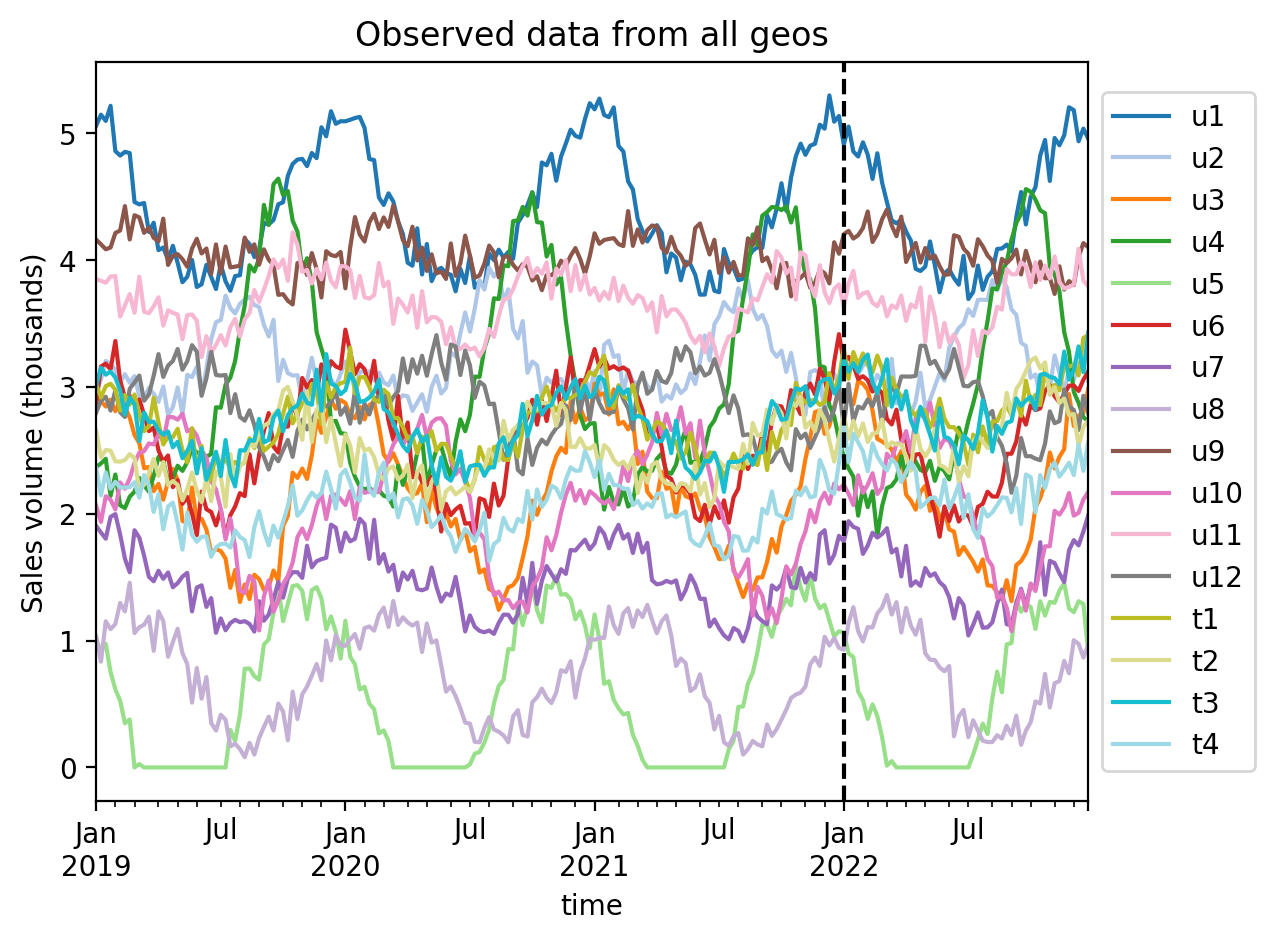

In [5]:
ax = df.plot(colormap="tab20")
ax.axvline(treatment_time, color="k", linestyle="--")
ax.set(title="Observed data from all geos", ylabel="Sales volume (thousands)")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));

We can see that each geo has some seasonality component as well as some noise. The treatment (vertical dashed line) is the same in each geo. The question is: to what extent did we get uplift in our KPI in each treated geo?

## Pre-experiment diagnostics: market correlations

With 16 geos in the panel, it helps to check which units co-move before fitting any model. The correlation heatmap below shows pairwise Pearson correlations computed on the pre-treatment window. Treated units that are highly correlated with several control units are easier to reconstruct via synthetic control.

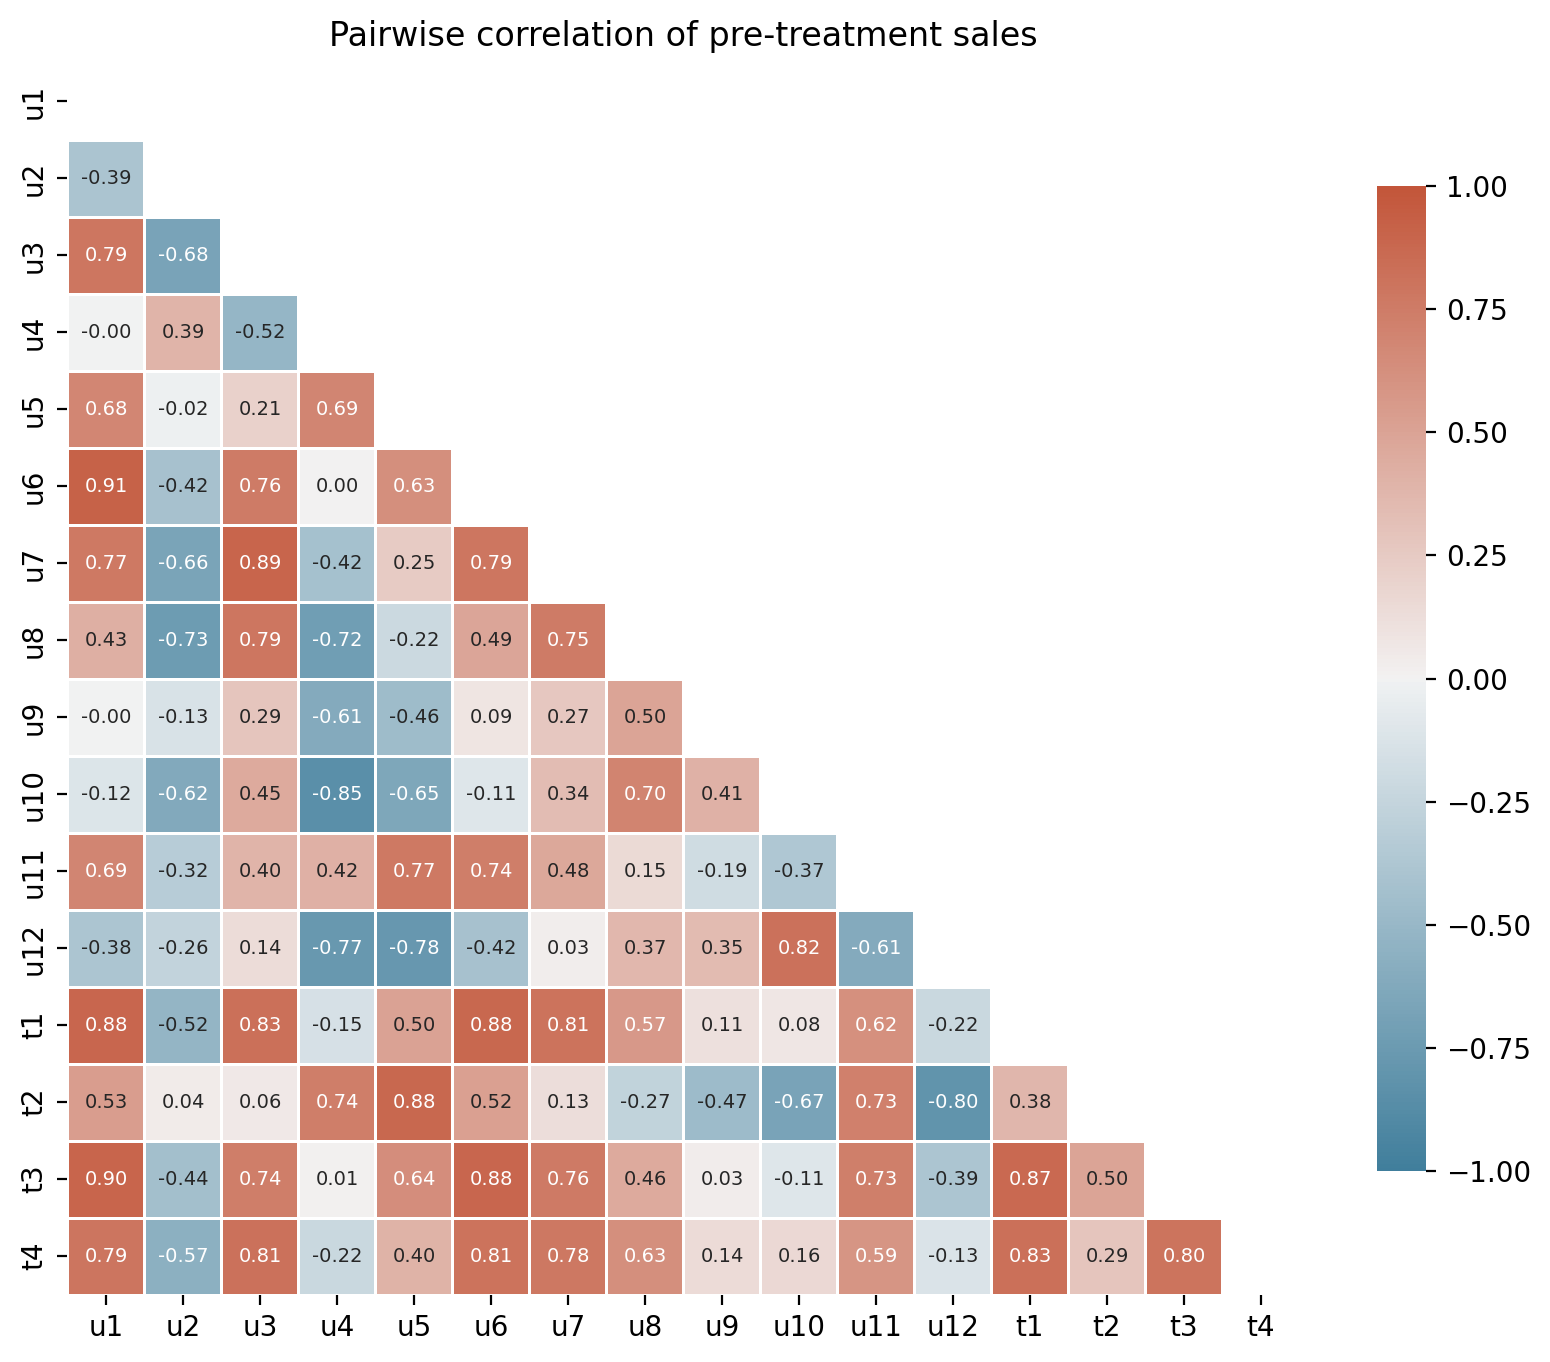

In [6]:
pre_treatment = df.loc[df.index < treatment_time]
corr, ax = cp.plot_correlations(pre_treatment, figsize=(10, 8), annot_kws={"size": 7})
ax.set(title="Pairwise correlation of pre-treatment sales");

Most control geos are positively correlated with the treated units, but a few show **negative correlations**. Including negatively correlated donors can introduce interpolation bias and degrade the {term}`synthetic control` fit {cite}`abadie2010synthetic,abadie2021using`. {cite:t}`abadie2021penalized` further show that dissimilar donors amplify estimation error.

### {term}`Donor pool selection`

We identify and exclude any control units that are negatively correlated with _any_ of the treated units. This is conservative but appropriate, especially for Bayesian implementations where the Dirichlet prior assigns non-zero weight to every donor.

In [7]:
corr_with_treated = corr.loc[untreated, treated]
bad_donors = corr_with_treated.index[(corr_with_treated < 0).any(axis=1)].tolist()
good_donors = [u for u in untreated if u not in bad_donors]
print(f"Excluding {len(bad_donors)} donors: {bad_donors}")
print(f"Keeping {len(good_donors)} donors: {good_donors}")

untreated = good_donors

Excluding 6 donors: ['u2', 'u4', 'u8', 'u9', 'u10', 'u12']
Keeping 6 donors: ['u1', 'u3', 'u5', 'u6', 'u7', 'u11']


With the poorly correlated geos removed, the remaining control pool consists of units that co-move with the treated geos. All subsequent analyses use this curated donor pool.

## Pooled analysis approach

The first analysis approach is to aggregate the treated geos and analyze them as a group. We recommend using `mean` (the ATT, i.e. per-geo impact) as the aggregation function, as these have clear causal interpretations in the Synthetic Control framework. In the code cell below we aggregate with `mean`.

::::{admonition} Why the choice of aggregation function matters for causal identification
:class: important

When combining multiple treated geos into a single aggregate before fitting a Synthetic Control model, the choice of aggregation function has direct consequences for causal identification.

**The key structural assumption** of Synthetic Control is that the counterfactual of the treated unit lives in the linear span of the control units. That is, for each treated geo $i$ with outcome $Y_i(t)$, there exist weights $w_{ij}$ such that the counterfactual (no-treatment) outcome satisfies $Y_i(t, 0) = \sum_j w_{ij} \, Y_j(t)$, where $j$ indexes the control geos and $Y_j(t) = Y_j(t, 0)$ since controls receive no treatment.

**`sum` and `mean` preserve this linear structure** and therefore produce well-defined causal estimands:

- **Sum aggregation**: The observed aggregate is $\sum_i Y_i(t, 1)$. Because summation is linear, the sum of individual counterfactuals is *also* in the span of the controls: $\sum_i Y_i(t, 0) = \sum_j \bigl(\sum_i w_{ij}\bigr) Y_j(t)$. So the Synthetic Control model can validly construct a counterfactual for the summed series. The estimated impact equals the **total causal effect on the treated** (summed across all treated geos at each time period).

- **Mean aggregation**: Algebraically equivalent — just divided by $n$ (the number of treated geos). The estimated impact equals the **ATT** (average treatment effect on the treated, per geographic unit).

**`median` breaks the linear structure** and is problematic for three reasons:

1. **The aggregated series may not be representable as a weighted sum of controls.** Even if each individual $Y_i(t, 0)$ is perfectly a weighted sum of controls, $\text{median}_i(Y_i(t, 0)) \neq \sum_j w_j \, Y_j(t)$ in general, because median is a non-linear operator. This violates the core assumption of Synthetic Control.

2. **The estimand is undefined.** The treatment effect on the median is *not* the same as the median treatment effect: $\text{median}_i(Y_i(t,1)) - \text{median}_i(Y_i(t,0)) \neq \text{median}_i(\tau_i(t))$. So the "impact" estimated from a median-aggregated Synthetic Control does not correspond to any standard causal quantity — it is neither the total causal effect on the treated, nor the ATT, nor even the median treatment effect on the treated.

3. **The "median geo" changes identity over time.** At time $t_1$ the median observation might come from geo A; at $t_2$ from geo B. The Synthetic Control model is then asked to match a series that does not track a consistent data-generating process, which can produce unstable or misleading weights.

**When might median be approximately acceptable?** If the treated geos are very similar (which is exactly the scenario the pooled approach assumes), then median $\approx$ mean and the distinction is small in practice. If one geo has clear data quality issues, median offers robustness — but it is more principled to either exclude the problematic geo or use a trimmed mean.

**Recommendation**: Use `sum` (total impact across treated geos) or `mean` (the ATT) for the pre-estimation aggregation of treated geos.
::::

In [8]:
df["treated_agg"] = df[treated].mean(axis=1)
df.head()

,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,t1,t2,t3,t4,treated_agg
time,,,,,,,,,,,,,,,,,
2019-01-06,5.06,2.97,2.96,2.37,1.00,2.87,1.90,1.03,4.16,2.06,3.85,2.80,3.02,2.65,3.01,2.36,2.76
2019-01-13,5.14,3.06,2.89,2.40,0.92,3.16,1.85,0.83,4.12,1.93,3.83,2.89,2.91,2.44,3.15,2.14,2.66
2019-01-20,5.09,3.20,2.84,2.43,0.97,3.18,1.80,1.15,4.08,2.14,3.82,2.92,3.00,2.50,3.09,2.32,2.73
2019-01-27,5.21,3.18,2.90,2.14,0.75,3.14,1.97,1.09,4.10,2.11,3.87,2.81,3.02,2.50,3.12,2.20,2.71
2019-02-03,4.86,3.14,2.81,2.31,0.61,3.36,2.00,1.13,4.21,2.03,3.87,2.97,2.98,2.41,3.07,2.25,2.68


Let's visualise this aggregated geo and compare it to the individual treated geo's.

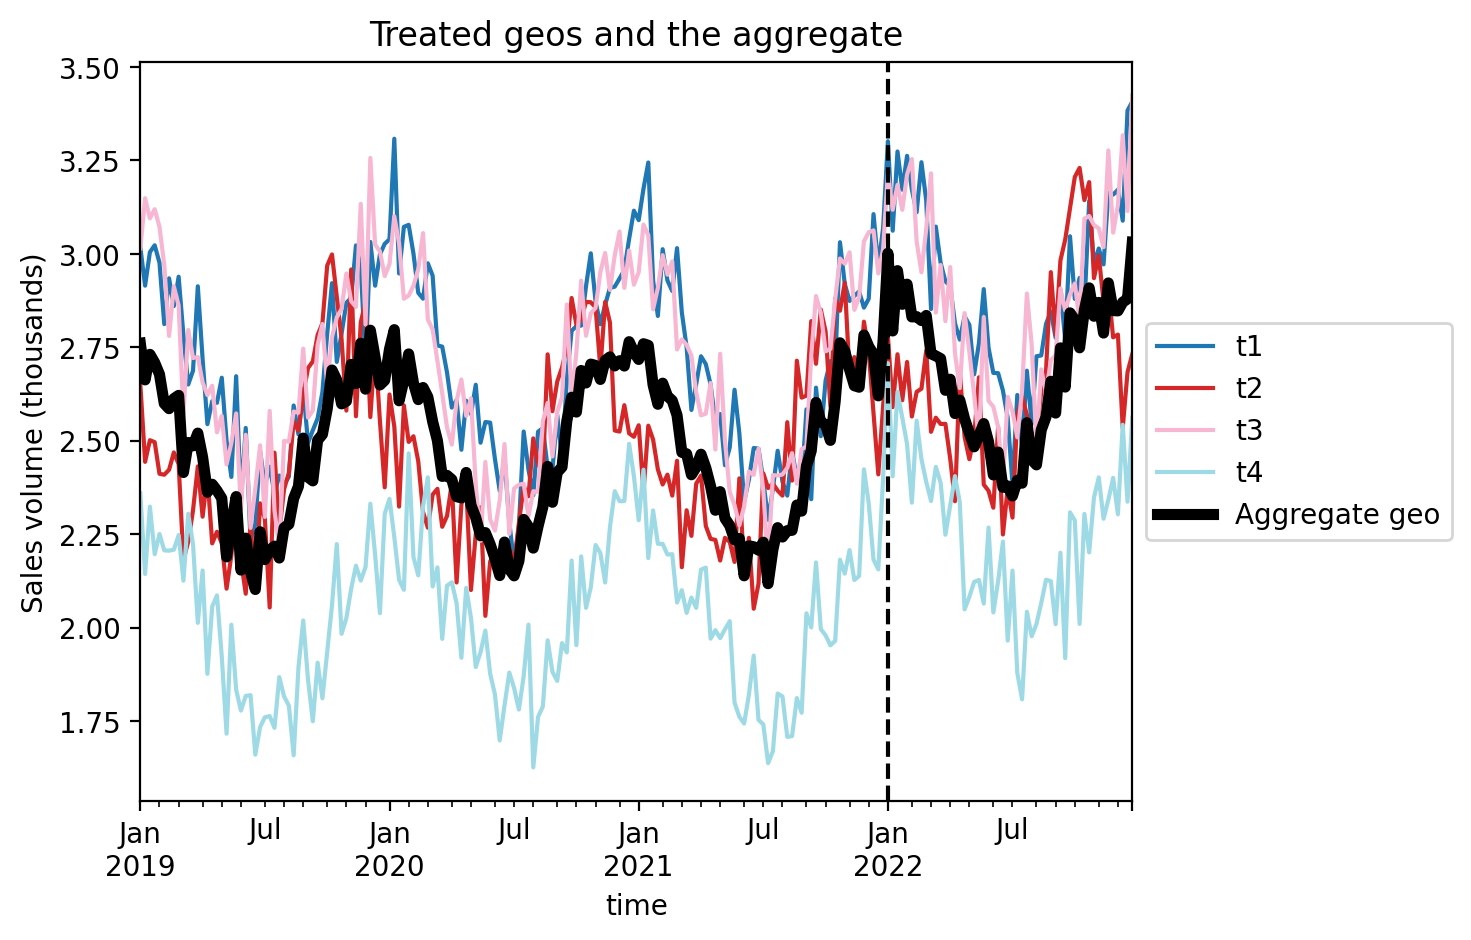

In [9]:
ax = df[treated].plot(colormap="tab20")
df["treated_agg"].plot(color="k", lw=4, ax=ax, label="Aggregate geo")
ax.axvline(treatment_time, color="k", linestyle="--")
ax.set(title="Treated geos and the aggregate", ylabel="Sales volume (thousands)")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5));

Now we just proceed as we would with a regular single-geo analysis.

Then we'll fit the model and print the summary.

In [10]:
pooled = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=untreated,
    treated_units=["treated_agg"],
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [11]:
pooled.summary()

================================SyntheticControl================================
Control units: ['u1', 'u3', 'u5', 'u6', 'u7', 'u11']
Treated unit: treated_agg
Model coefficients:
    u1           0.021, 94% HDI [0.0009, 0.052]
    u3           0.024, 94% HDI [0.00095, 0.063]
    u5           0.09, 94% HDI [0.066, 0.11]
    u6           0.017, 94% HDI [0.00083, 0.052]
    u7           0.4, 94% HDI [0.35, 0.45]
    u11          0.45, 94% HDI [0.41, 0.47]
    y_hat_sigma  0.087, 94% HDI [0.078, 0.097]
Pre-treatment correlation (treated_agg): 0.9316


We can see the model weightings visually like this:

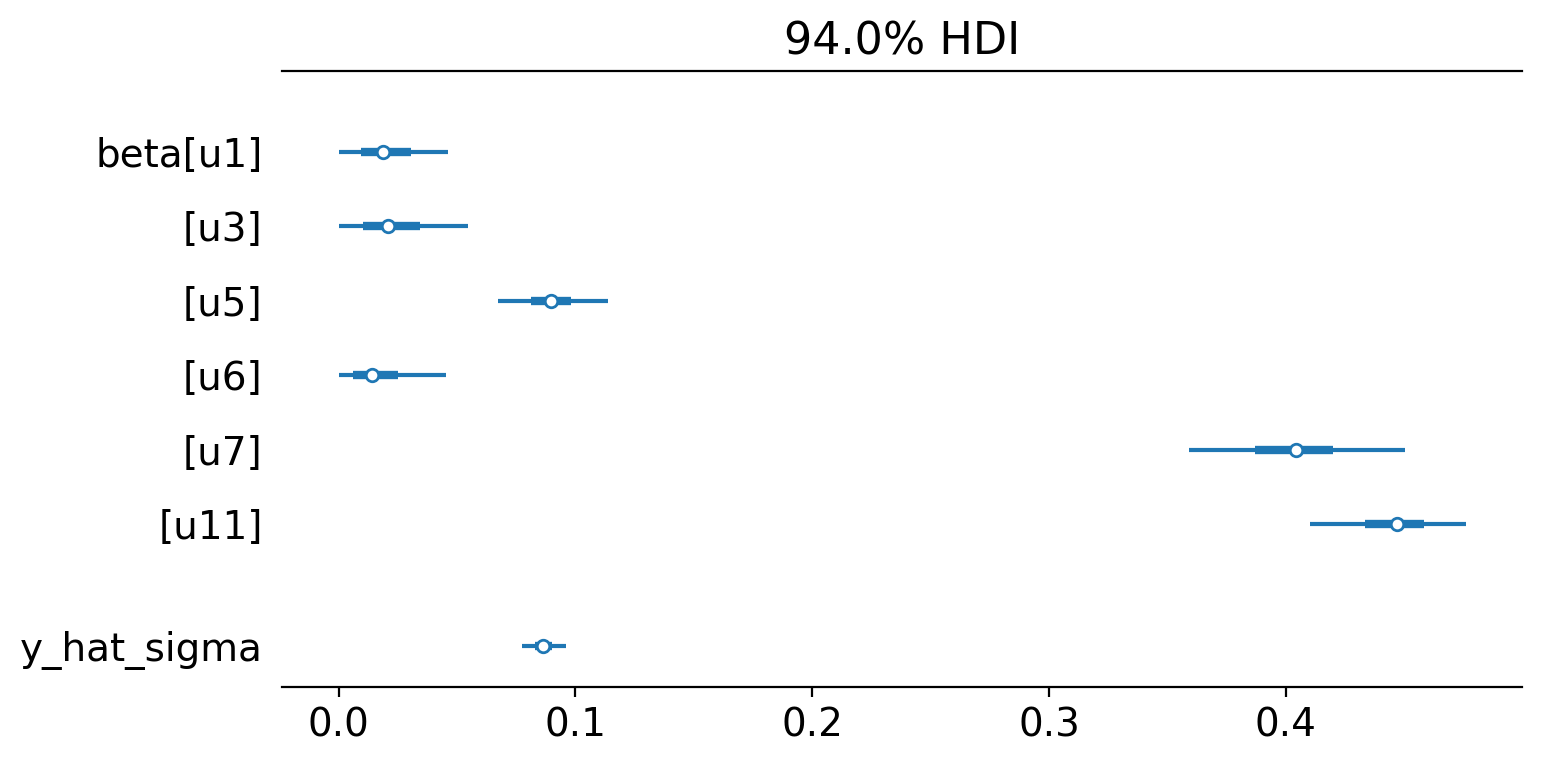

In [12]:
az.plot_forest(pooled.idata, var_names=["~mu"], figsize=(8, 4), combined=True);

And of course we can see the causal impact plot using the `plot` method.

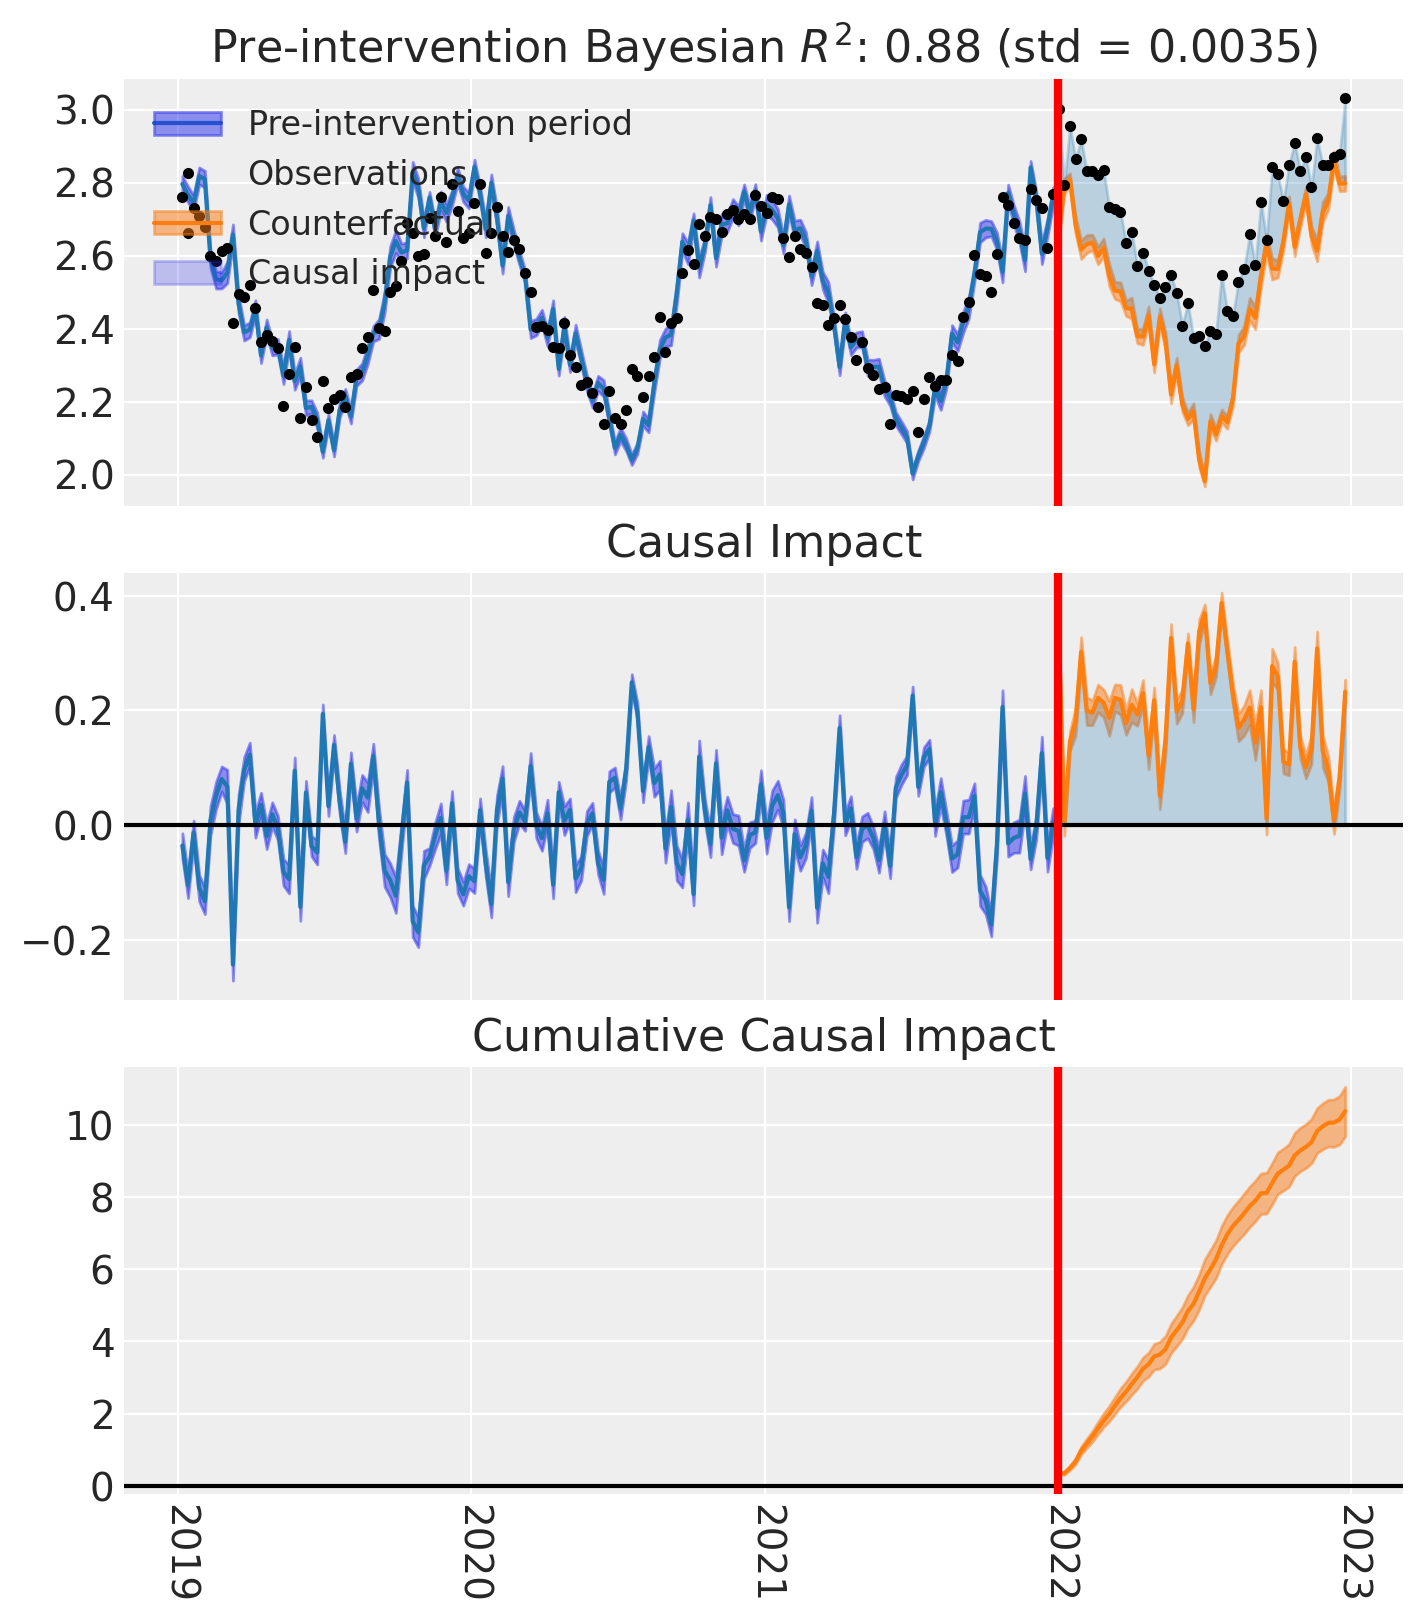

In [13]:
fig, ax = pooled.plot(plot_predictors=False, figsize=(15, 4))

# formatting
for i in [0, 1, 2]:
    ax[i].set(ylabel="Sales (thousands)")

## Unpooled analysis

The second analysis approach is to analyze each treated geo individually. We can do this in one shot by providing a list of treated geos to the `SyntheticControl` class.

In [14]:
treated

['t1', 't2', 't3', 't4']

In [15]:
untreated

['u1', 'u3', 'u5', 'u6', 'u7', 'u11']

In [16]:
result_unpooled = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=untreated,
    treated_units=treated,
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


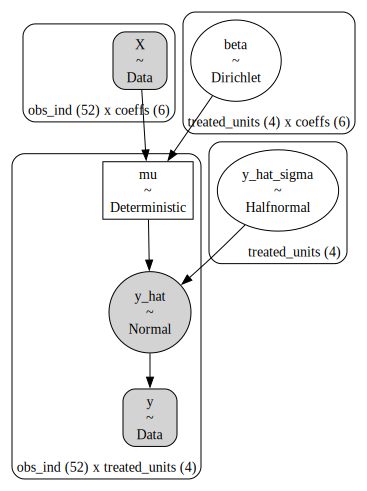

In [17]:
result_unpooled.model.to_graphviz()

We can get the summary of the posterior of the weighting coefficients (and the observation noise standard deviation) like this:

In [18]:
result_unpooled.summary()

================================SyntheticControl================================
Control units: ['u1', 'u3', 'u5', 'u6', 'u7', 'u11']
Treated units: ['t1', 't2', 't3', 't4']
Model coefficients:

Treated unit: t1
    u1           0.11, 94% HDI [0.032, 0.18]
    u3           0.1, 94% HDI [0.019, 0.19]
    u5           0.013, 94% HDI [0.00045, 0.037]
    u6           0.036, 94% HDI [0.0017, 0.1]
    u7           0.37, 94% HDI [0.28, 0.46]
    u11          0.37, 94% HDI [0.29, 0.44]
    y_hat_sigma  0.12, 94% HDI [0.1, 0.13]

Treated unit: t2
    u1           0.0056, 94% HDI [0.00016, 0.02]
    u3           0.0064, 94% HDI [0.00017, 0.022]
    u5           0.29, 94% HDI [0.25, 0.33]
    u6           0.0082, 94% HDI [0.00033, 0.027]
    u7           0.14, 94% HDI [0.079, 0.2]
    u11          0.56, 94% HDI [0.53, 0.58]
    y_hat_sigma  0.16, 94% HDI [0.15, 0.18]

Treated unit: t3
    u1           0.12, 94% HDI [0.059, 0.18]
    u3           0.047, 94% HDI [0.0025, 0.12]
    u5           0.0

We can also plot the weights of the untreated geos for each of the treated geos in a single plot. Each colour represents a different treated geo (see the legend).

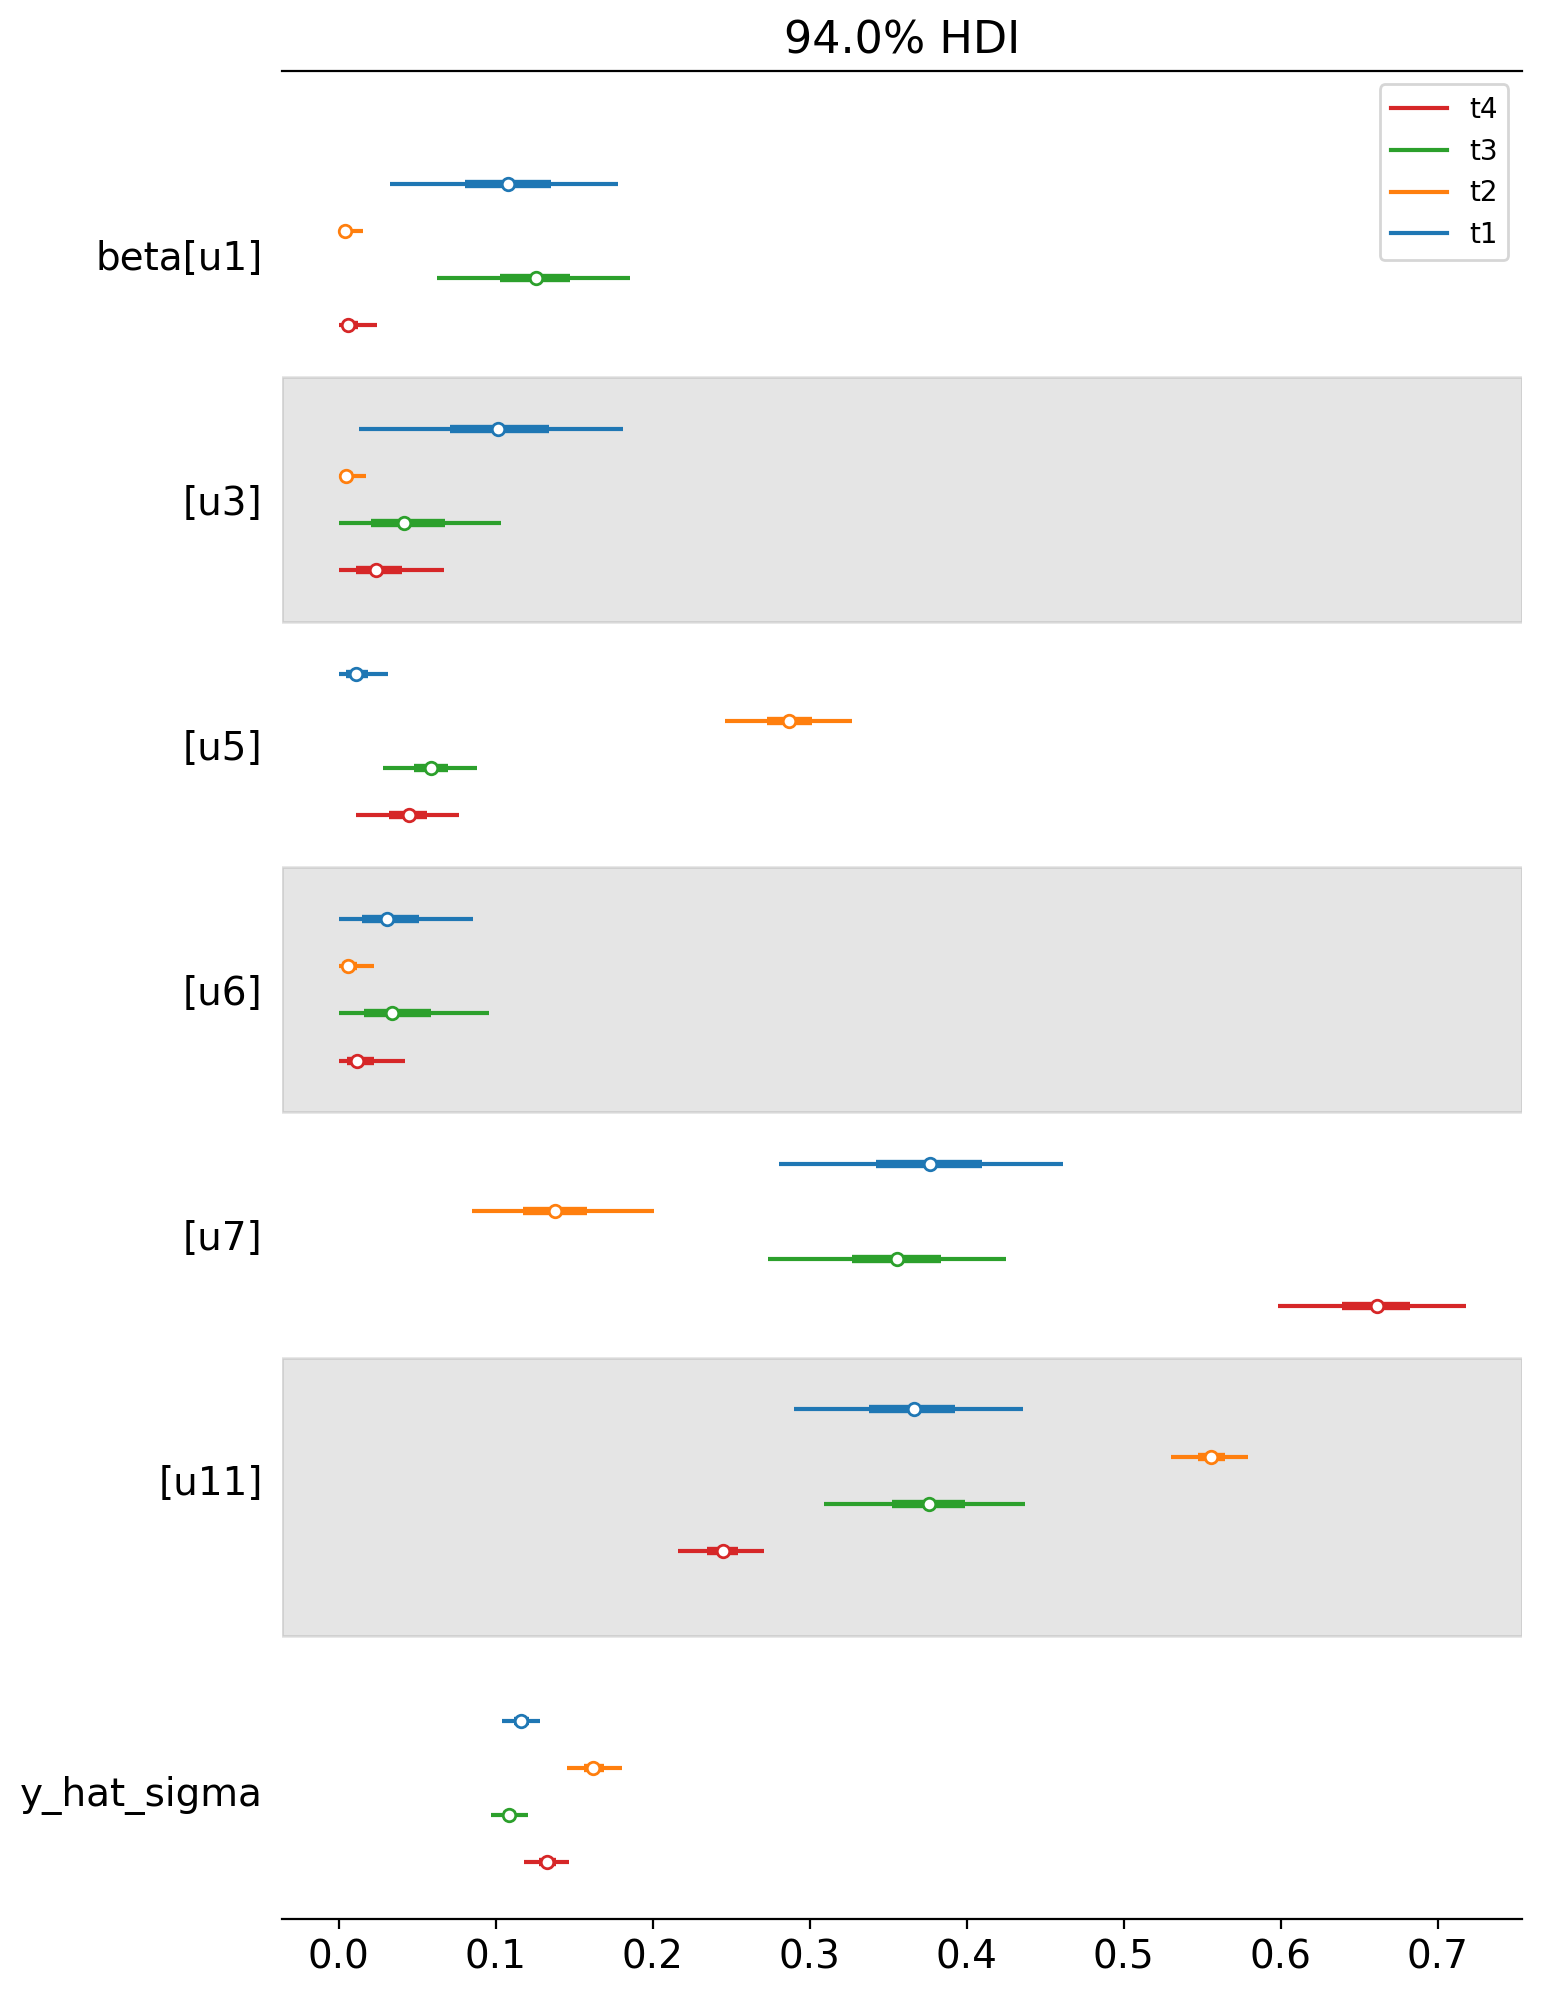

In [19]:
az.plot_forest(
    [
        result_unpooled.idata.posterior.sel(treated_units=treated_unit)
        for treated_unit in treated
    ],
    model_names=treated,
    var_names=["~mu"],
    combined=True,
    figsize=(8, 12),
);

And let's also plot the idiomatic causal impact plot for each treated geo.

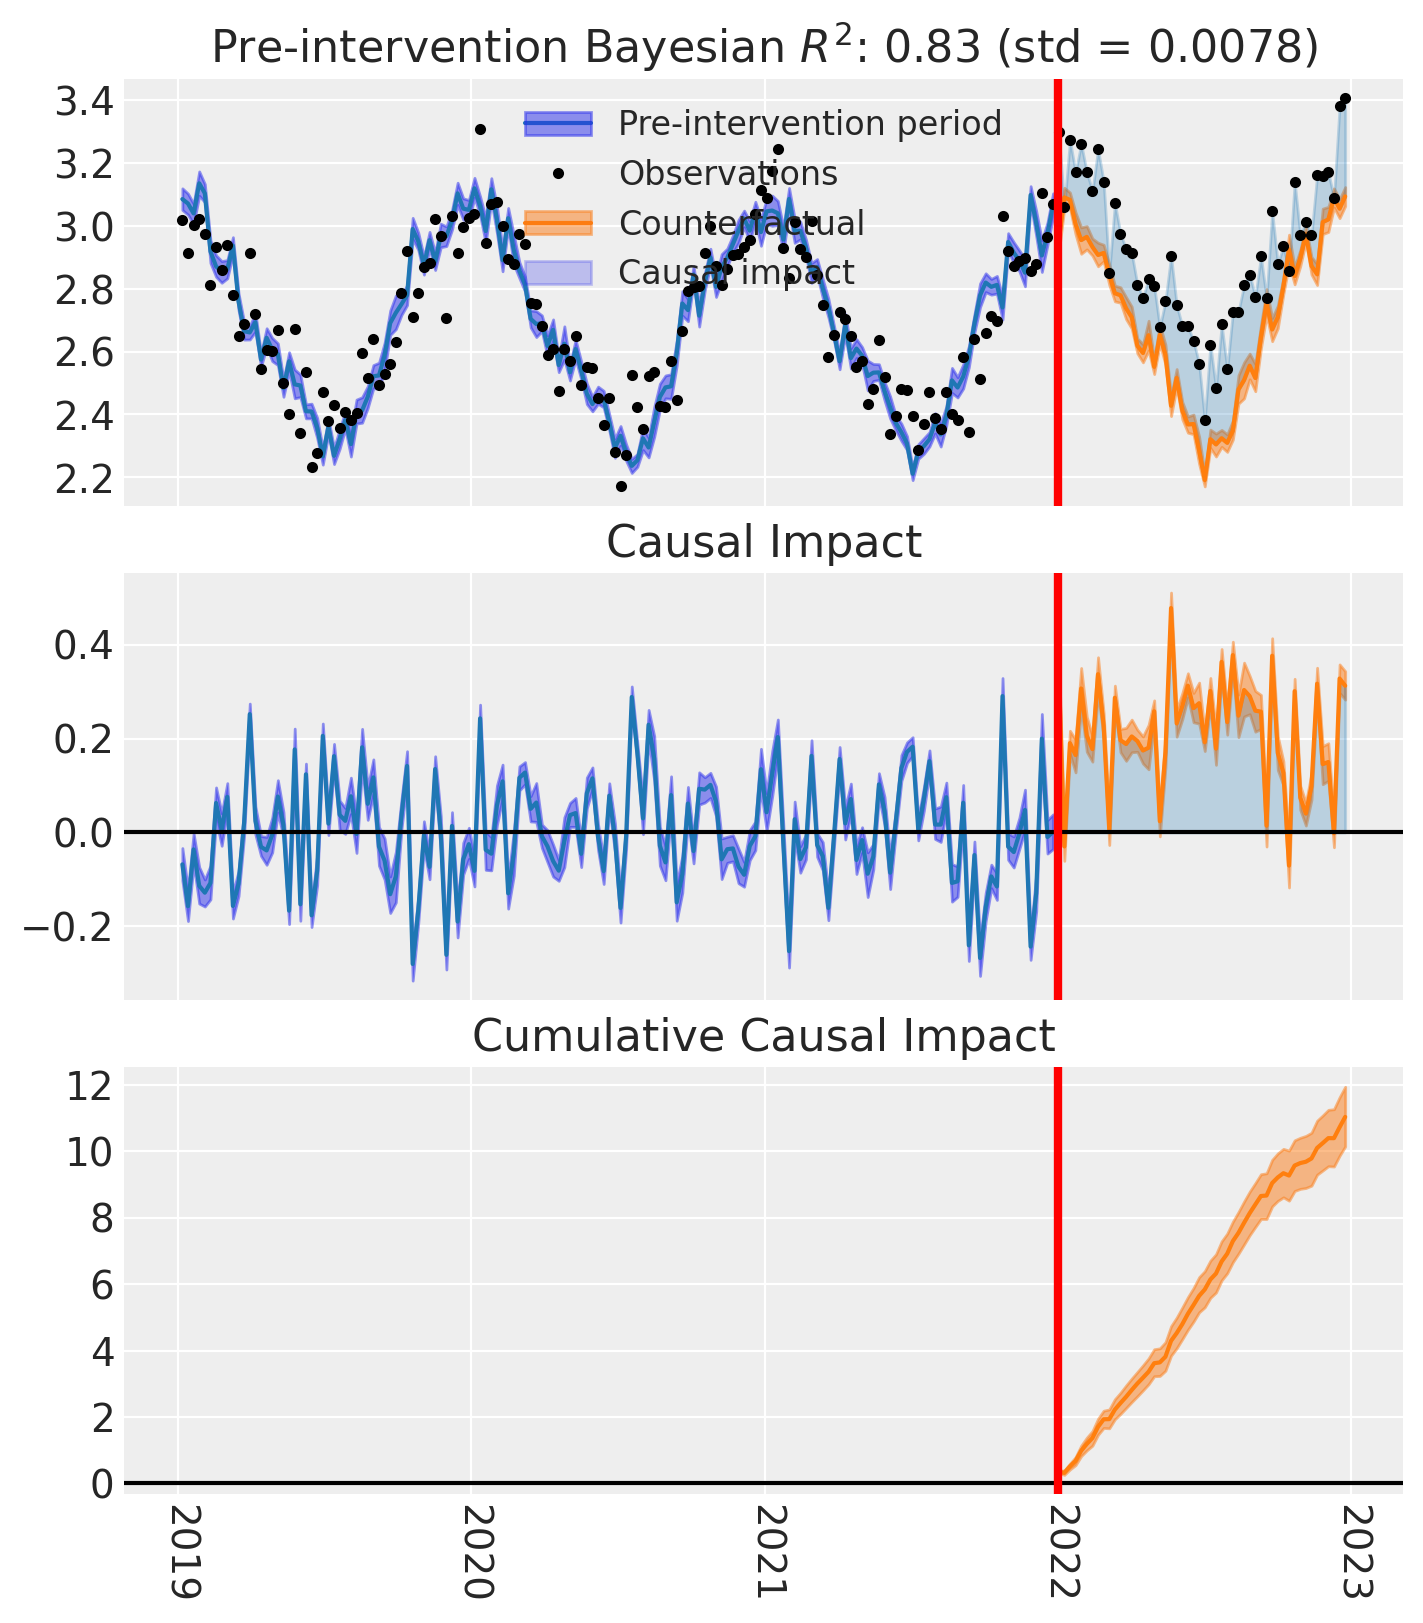

<Figure size 640x480 with 0 Axes>

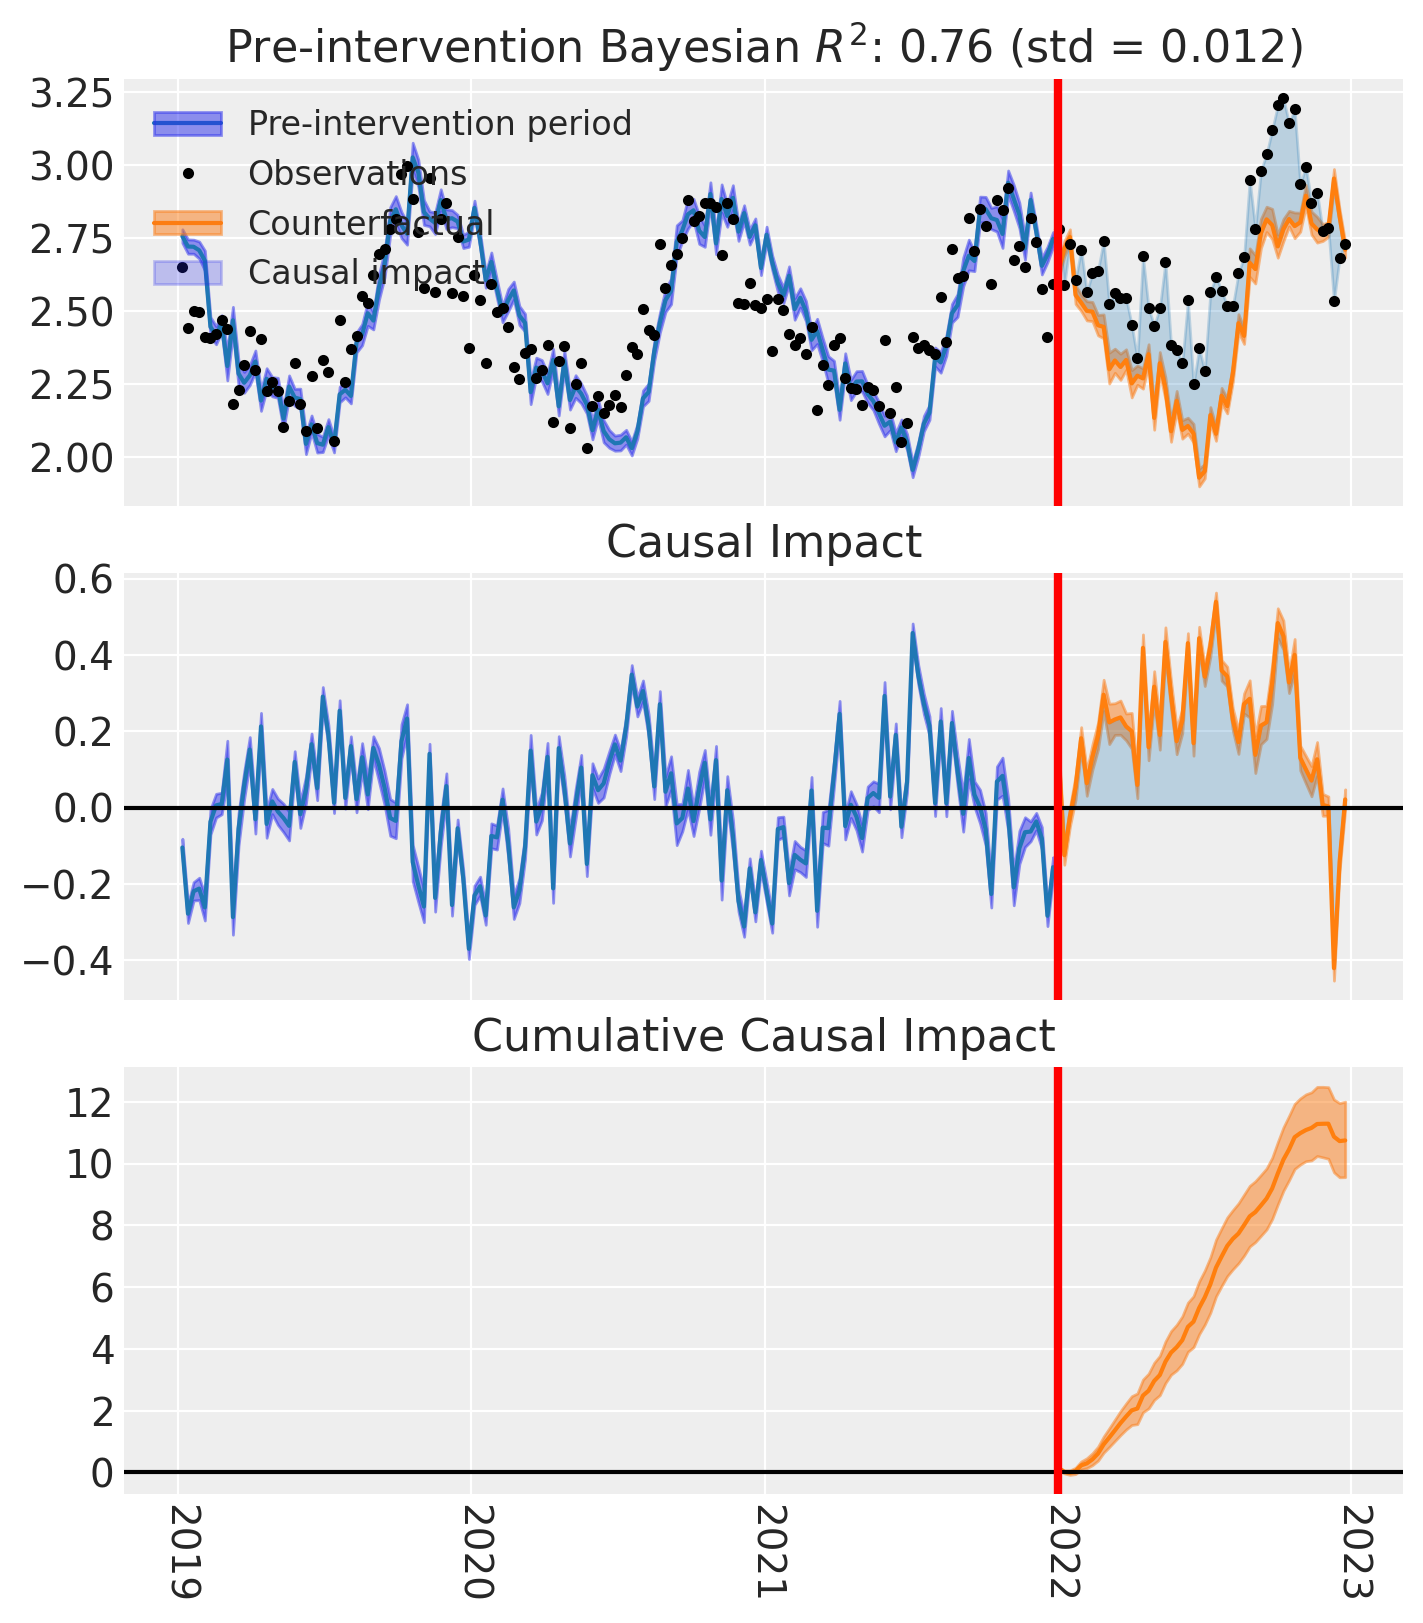

<Figure size 640x480 with 0 Axes>

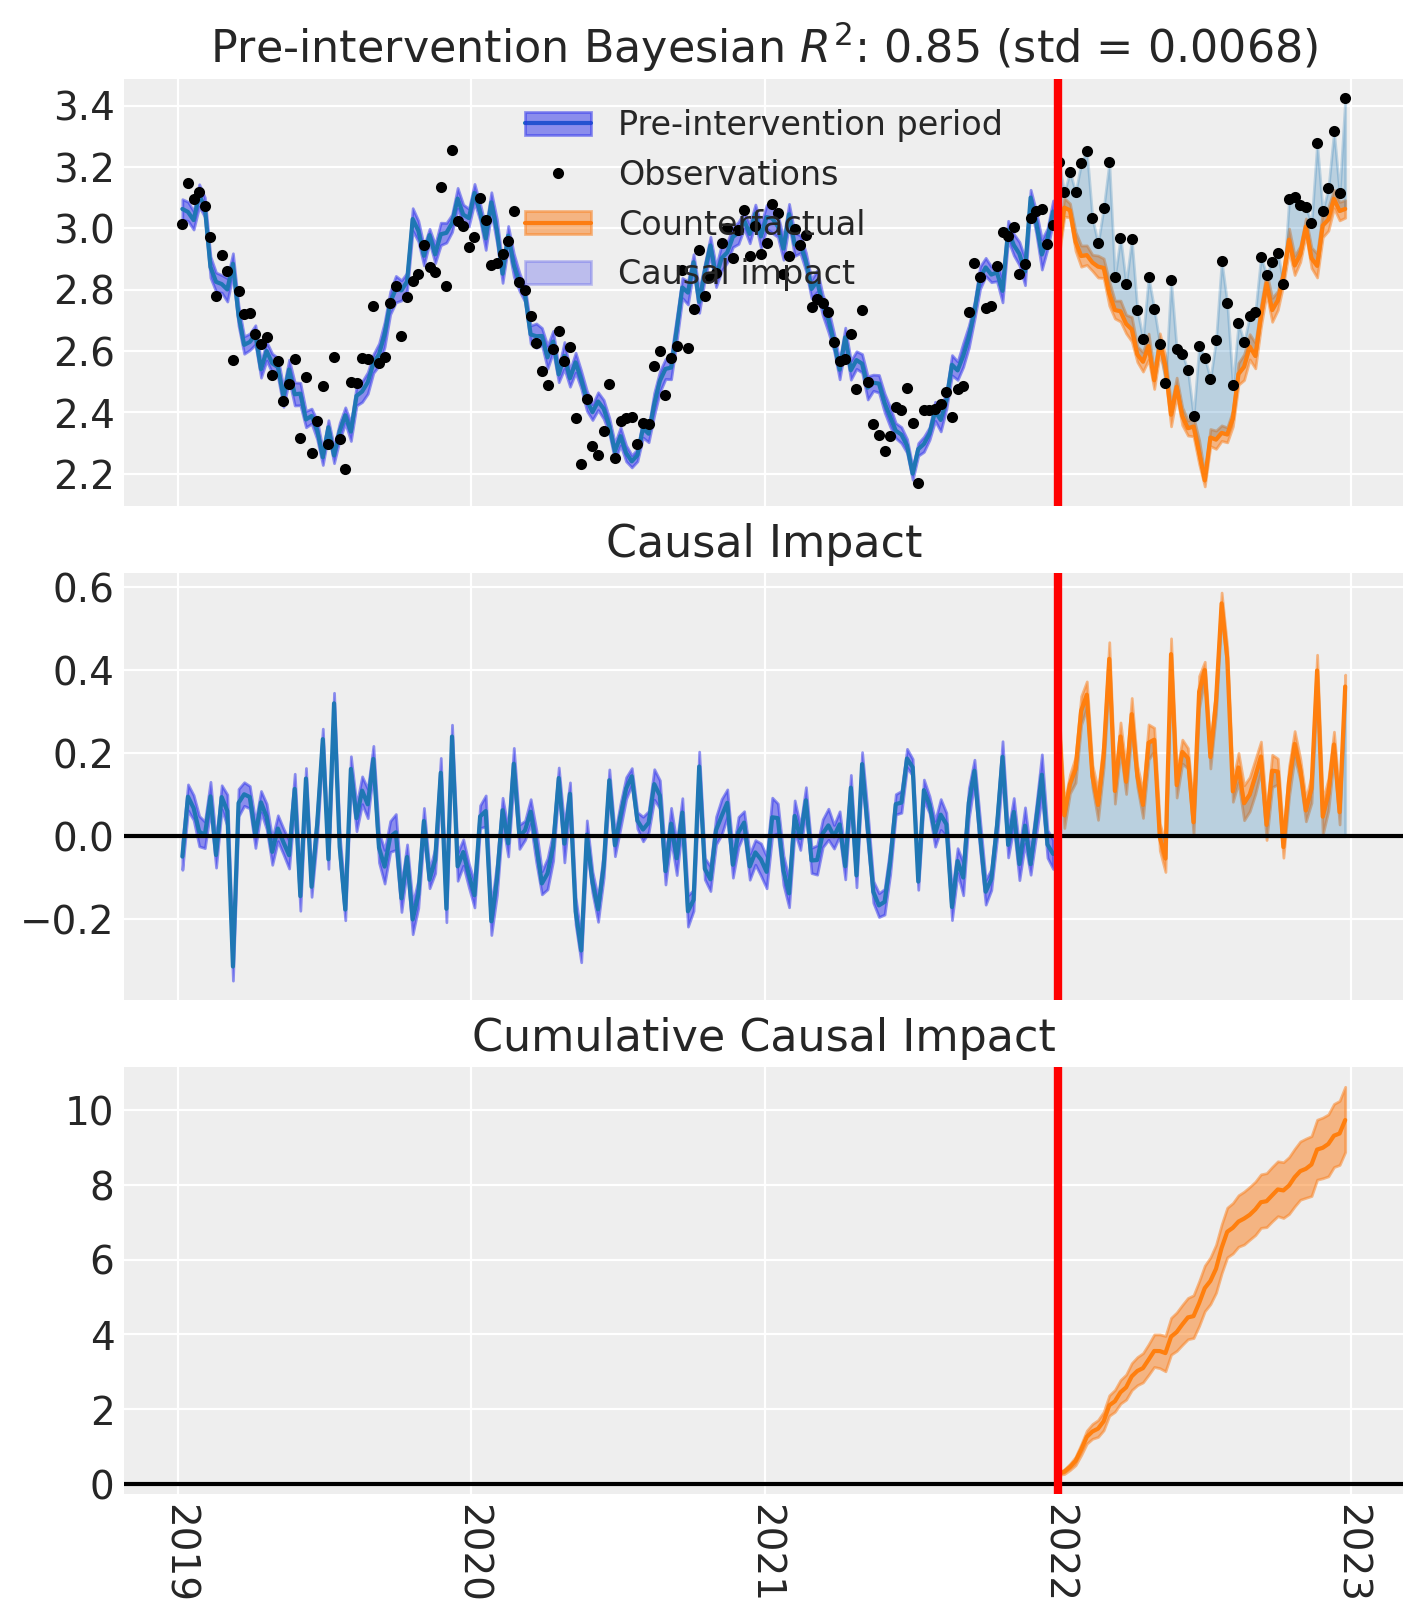

<Figure size 640x480 with 0 Axes>

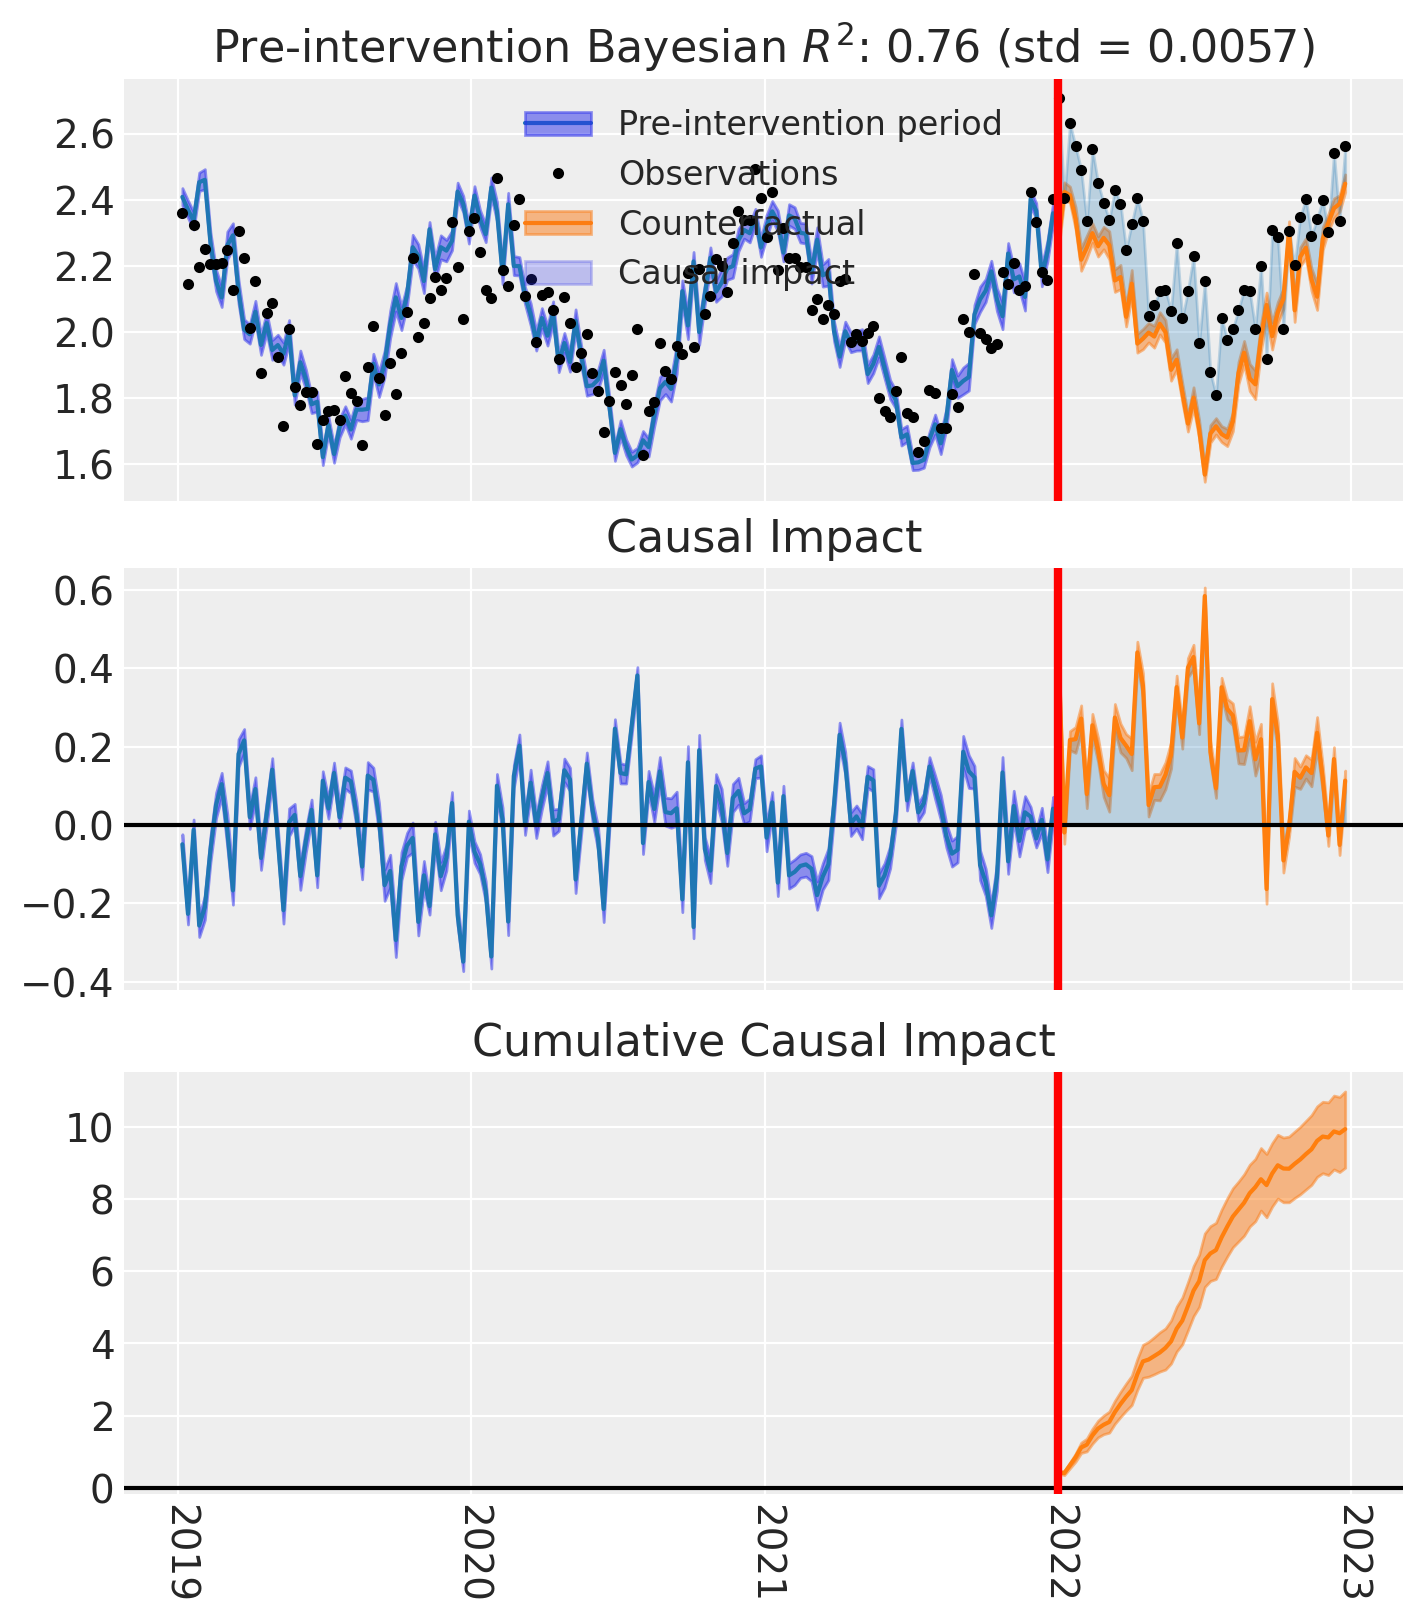

<Figure size 640x480 with 0 Axes>

In [20]:
for t in treated:
    fig, ax = result_unpooled.plot(treated_unit=t)

    # formatting
    ax[2].tick_params(axis="x", labelrotation=-90)
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax[2].xaxis.set_major_locator(mdates.YearLocator())
    for i in [0, 1, 2]:
        ax[i].set(ylabel="Sales (thousands)")
    plt.suptitle(f"Causal impact for {t}")

We've seen in this section that it is not just possible, but very easy to analyse geo lift result data when there are multiple treated geos. This approach essentially just iterates through each treated geo and analyses them individually.

This does of course mean that if we have a large number of treated geos, we will have a large number of results and plots to look at, but this is fine. 

## Comparing the two approaches

Let's compare the two approaches by plotting the posterior distribution of the cumulative causal impact over the whole post-treatment period.

It is important to note that these two approaches estimate different quantities:

- **Pooled (with `mean` aggregation):** estimates the **cumulative ATT** — the causal effect per treated geo, accumulated over the post-treatment period.
- **Unpooled:** estimates the **individual geo cumulative ATT** — the causal effect for each treated geo separately, accumulated over the post-treatment period.

To make this distinction clear, we plot them on separate axes with a shared x-scale:

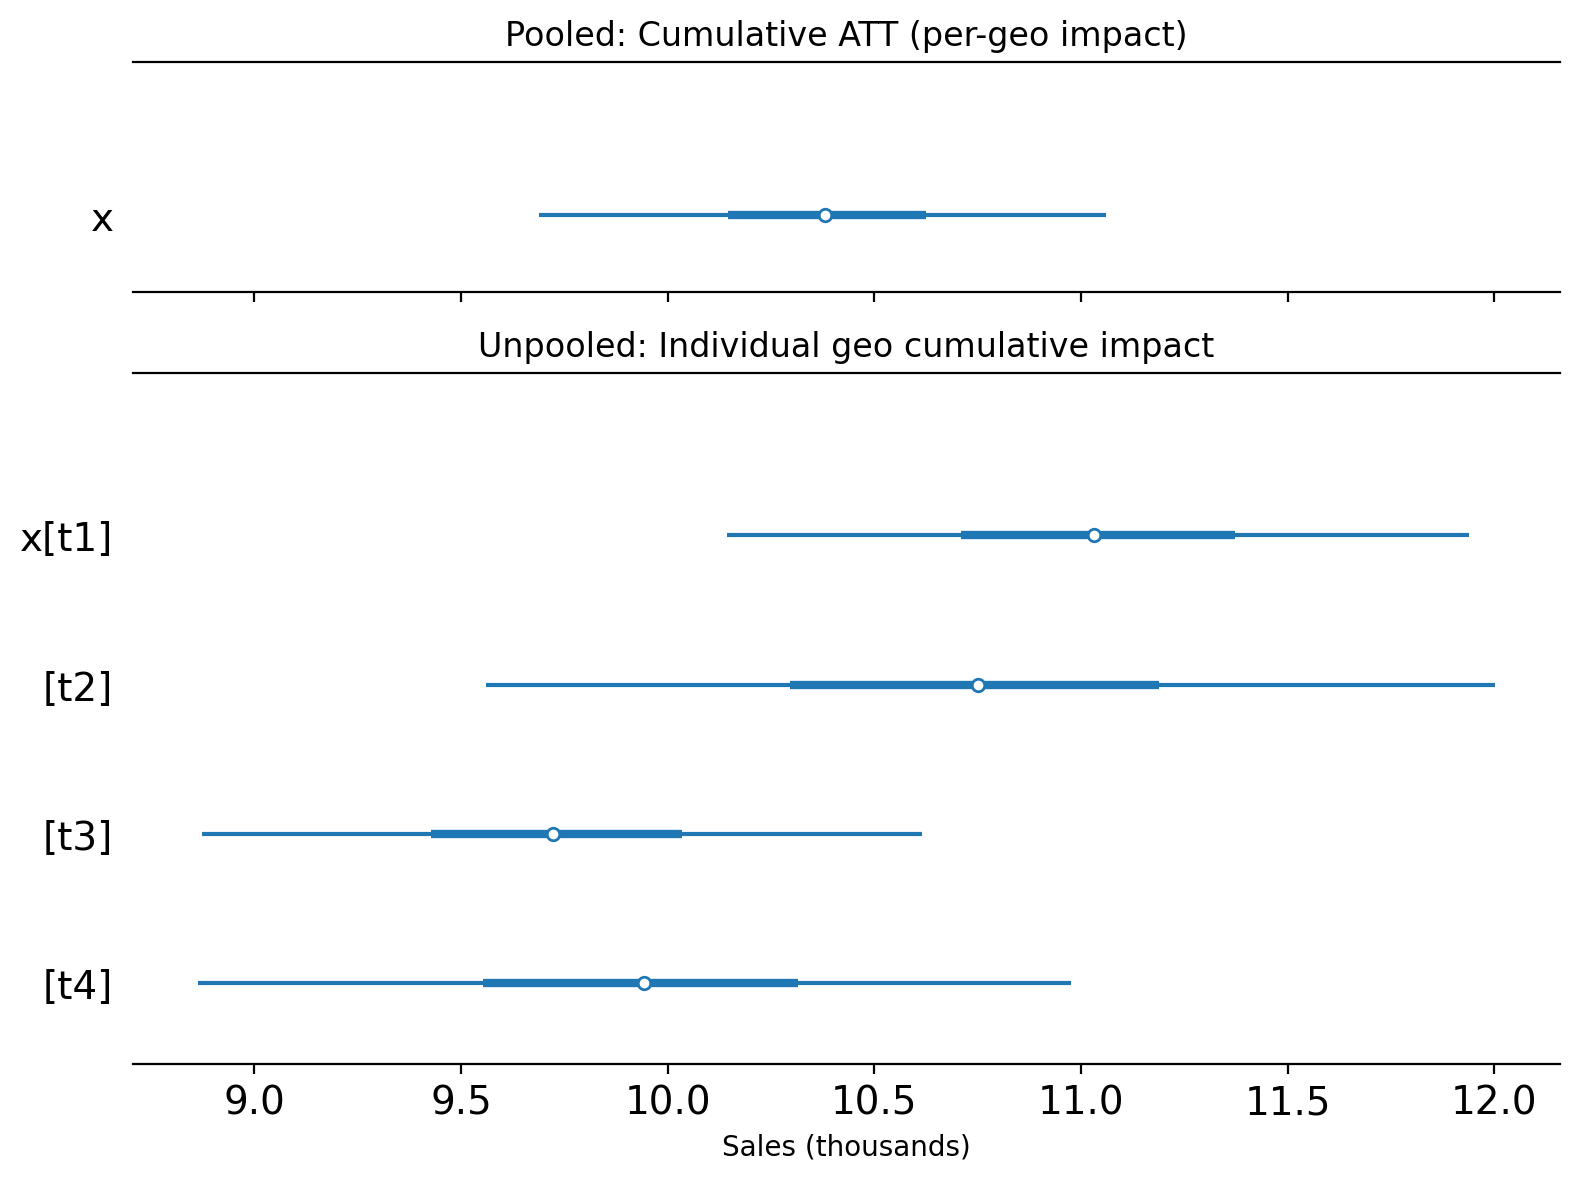

In [21]:
final_time_point = pooled.post_impact_cumulative.obs_ind.max()

pooled_cumulative = pooled.post_impact_cumulative.isel(treated_units=0).sel(
    obs_ind=final_time_point
)

unpooled_cumulative = result_unpooled.post_impact_cumulative.sel(
    obs_ind=final_time_point
)

fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [1, 3]}
)

az.plot_forest(pooled_cumulative, combined=True, ax=ax_top)
ax_top.set(title="Pooled: Cumulative ATT (per-geo impact)", ylabel="")

az.plot_forest(unpooled_cumulative, combined=True, ax=ax_bottom)
ax_bottom.set(
    title="Unpooled: Individual geo cumulative impact",
    xlabel="Sales (thousands)",
    ylabel="",
)

fig.tight_layout();

For this particular (simulated) dataset, the pooled and individual unpooled point estimates land in roughly the same region of the x-axis. This is expected because the treatment was the same in each geo, and the true causal impact was similar across all treated geos. We'd likely see more variation in the estimates of the unpooled models if the real causal impacts were more heterogeneous across the geos.

:::{note}
**Why is the pooled estimate more precise?**

The pooled model's credible interval is noticeably narrower than any individual unpooled estimate. This is **expected and correct** — it is a direct consequence of noise reduction from averaging.

When we aggregate the 4 treated geos using `mean`, the idiosyncratic observation noise in each geo partially cancels out. For independent noise, variance is divided by $n$, so the standard deviation drops by a factor of $\sqrt{n} = 2$ for $n = 4$ geos (in practice, correlated shocks across geos would reduce this gain, but the direction of the effect is the same). The Synthetic Control model then fits a tighter counterfactual to this smoother aggregated series, leading to a more precise posterior.

The narrower credible interval reflects genuine statistical efficiency: we can estimate the **ATT** more precisely than we can estimate **any single geo's effect**. However, there is a trade-off:

- **If effects are homogeneous** (as in this simulation): the pooled estimate accurately summarises the common effect with high precision.
- **If effects are heterogeneous** across geos: the pooled model might give a falsely precise estimate of an "average" that does not represent any individual geo well, while masking real variation in treatment effects.

This is one key reason why looking at both the pooled and unpooled analyses together is valuable: it lets you assess both the average effect (efficiently) and the degree of heterogeneity across treated geos.
:::

If you are using multi-cell Synthetic Control for lift test evaluation to calibrate a Media Mix Model (MMM), the choice between pooled and unpooled results also depends on the granularity of your MMM. If your MMM operates at the national or aggregate level (no geo dimension), the **pooled** estimate is the natural fit — one average lift value to calibrate a single saturation curve. If your MMM includes a geo dimension, the **unpooled** estimates are more appropriate — they provide individual geo-level lift values that can calibrate geo-specific curves.

## Using Results for MMM Calibration

If you're using geo-lift experiments to calibrate a Media Mix Model (MMM), you'll need to extract the lift estimates in a specific format. CausalPy provides the `extract_lift_for_mmm()` helper function to format your Synthetic Control results for use with [PyMC-Marketing's `add_lift_test_measurements()` method](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_lift_test.html).

PyMC-Marketing's lift test calibration expects a DataFrame with the following columns:

| Column | Description |
|--------|-------------|
| `channel` | The marketing channel tested |
| `geo` | The geographic unit identifier (must match your MMM's geo dimension) |
| `x` | Pre-test spend level for the channel |
| `delta_x` | Spend increase during the test period |
| `delta_y` | Estimated causal lift (posterior mean) |
| `sigma` | Uncertainty in the lift estimate (posterior std) |

The `extract_lift_for_mmm()` function handles extracting these values from your fitted Synthetic Control model, including proper uncertainty quantification from the Bayesian posterior.

In [22]:
# Extract lift results from the unpooled model for MMM calibration
df_lift = cp.extract_lift_for_mmm(
    result_unpooled,
    channel="tv_campaign",  # Name of the channel being tested
    x=0.0,  # Pre-test spend (0 if this was a new channel activation)
    delta_x=10000,  # Additional spend during the test period
    aggregate="mean",  # Average lift per time period
)

df_lift

,channel,geo,x,delta_x,delta_y,sigma
0,tv_campaign,t1,0.0,10000,0.21,9.33e-03
1,tv_campaign,t2,0.0,10000,0.21,1.27e-02
2,tv_campaign,t3,0.0,10000,0.19,8.83e-03
3,tv_campaign,t4,0.0,10000,0.19,1.09e-02


This DataFrame is now ready to be used with PyMC-Marketing to calibrate your MMM's saturation curves:

```python
# In PyMC-Marketing (not run here as it requires pymc-marketing package):
# mmm.add_lift_test_measurements(df_lift)
```

:::{note}
The `aggregate` parameter controls how the lift is summarized across post-intervention time periods:
- `"mean"`: Average lift per time period. Use this when your MMM operates at the same time granularity as the experiment (e.g., weekly MMM with weekly experiment data).
- `"sum"`: Total cumulative lift across all periods. Use this when you want to report the total campaign impact.
- `"median"`: Median lift per time period. More robust to outliers than the mean; useful when the impact distribution across time periods is skewed.

Note that this is aggregation across *time periods* (a post-estimation summary), which is conceptually different from the pre-estimation aggregation across *geos* discussed earlier in the notebook.
:::

:::{warning}
**Generalisability caveat.** The lift estimates extracted here reflect the ATT — the causal effect measured in the geos where the treatment was actually deployed. If you are using these values to calibrate a national-level MMM (one without a geo dimension), you are implicitly assuming that the measured lift is representative of what would occur across *all* geos, including those that were not treated. This assumption is reasonable when treated geos were selected approximately at random or are otherwise representative of the broader geo population. However, if treated geos were cherry-picked — for instance, chosen because they were expected to respond strongly, or because they are large metro markets that differ systematically from the rest — then the calibrated saturation curves could be biased upward (or downward). Before feeding lift estimates into a national MMM, consider whether the test geos are representative of the broader population, and whether the measured ATT is a reasonable proxy for the ATE you need.
:::

For the full MMM calibration workflow, see the [PyMC-Marketing lift test documentation](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_lift_test.html).

## Summary

We've shown two methods that we can use to analyse geo lift data with multiple treated geos. To do this, we used a simulated dataset with seasonality and observation noise.

The first method is to aggregate the treated geos and analyze them as a single aggregated geo. This is useful when we expect the effects of the intervention to be similar in each treated region - for example if we deployed the same kind and magnitude of intervention in across the treated regions. This method is also useful when we have a large number of treated geos and we want to reduce the complexity of the modeling approach and create a single 'story' for the causal effects of the treatment across all treated geos.

The second method is to model all the treated geos in one model - we did this by giving the `SyntheticControl` class a list of treated geos. Currently, this is an unpooled model which will give equivalent results to running totally separate analyses of each treated region one at a time. This approach is useful when we want to understand the impact of each geo separately. This may make most sense if the treatments were different in kind or magnitude. That is, when we do not expect the effects of the intervention to be similar in each treated region.

An important point to bear in mind is that these two approaches target different causal estimands. The pooled model (with `mean` aggregation) estimates the **ATT** (the average causal effect per treated geo), while the unpooled model estimates **individual per-geo causal effects**. As a consequence, the pooled estimate will typically have a narrower credible interval — this is expected, because averaging reduces observation noise. This narrower interval reflects genuine statistical efficiency in estimating the average, not overconfidence. However, if treatment effects are heterogeneous across geos, the pooled average may not represent any individual geo well, making it valuable to examine both approaches side by side.

A further consideration is generalisability. Both approaches estimate the effect of the treatment on the geos that were actually treated — the ATT. Whether these estimates can be extrapolated to untreated geos depends on how representative the treated geos are of the broader population. If treated geos were selected approximately at random, generalisation is more defensible. But if they were cherry-picked — for example, because they were expected to respond well, or because they are large metro areas that differ systematically from smaller markets — then the measured ATT may not reflect what would happen elsewhere. This is especially important when using lift estimates to calibrate a Media Mix Model: feeding an ATT from non-representative geos into a national MMM implicitly assumes the effect applies everywhere, which could bias the calibrated saturation curves. The unpooled estimates can provide a useful diagnostic here — if the effect varies substantially even across the treated geos, it is a signal that extrapolation to untreated geos should be done with caution.

But what about a more complex scenario? We could imagine a situation where one intervention (e.g. a store refurbishment programme) was deployed in some geos, and a different intervention (e.g. a marketing campaign) was deployed in different geos. In this case, we could use a combination of the two methods we've shown here. We could aggregate the treated geos where the same intervention was deployed, and analyze the treated geos where different interventions were deployed separately.

Finally, we demonstrated how to extract the lift estimates in a format suitable for Media Mix Model (MMM) calibration using the `extract_lift_for_mmm()` helper function. This bridges the gap between CausalPy's geo-lift experiments and downstream MMM workflows in [PyMC-Marketing](https://github.com/pymc-labs/pymc-marketing).


## References

:::{bibliography}
:filter: docname in docnames
:::